In [1]:
import os
import sys
_path = os.path.abspath('..')
if _path not in sys.path:
    sys.path.append(_path)

import astropy.coordinates as coord
from astropy.io import fits
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from pyia import GaiaData
from sfd import reddening, ebv
from matplotlib.gridspec import GridSpec
from hq.config import Config
from scipy.stats import poisson

from gala.mpl_style import laguna

from helpers import rg_path, ms_path

In [2]:
figure_path = '../../tex/figures'
os.makedirs(figure_path, exist_ok=True)

In [3]:
c = Config.from_run_name('dr16-random')

In [4]:
allstar, allvisit = c.load_alldata()

In [5]:
binaries = at.QTable.read('../../catalogs/lnK0.0_logL4.6_metadata_gaia_starhorse.fits')

In [6]:
allgaia = at.QTable.read('../../catalogs/dr16_gaia_starhorse_metadata.fits')
for col in allgaia.colnames:
    allgaia[col].mask = None

## HR diagrams

In [7]:
allgaia_cut = GaiaData(allgaia[(allgaia['parallax'] / allgaia['parallax_error']) > 5])
binaries_cut = GaiaData(binaries[(binaries['parallax'] / binaries['parallax_error']) > 5])
len(allgaia_cut), len(binaries)

(164598, 17682)

In [8]:
def get_JHK0(g):
    c = g.get_skycoord()
    A_JHK = reddening(c, '2MASS', ['J', 'H', 'Ks'], ebv=g.get_ebv())
    return g.J - A_JHK[:, 0], g.H - A_JHK[:, 1], g.K - A_JHK[:, 2]

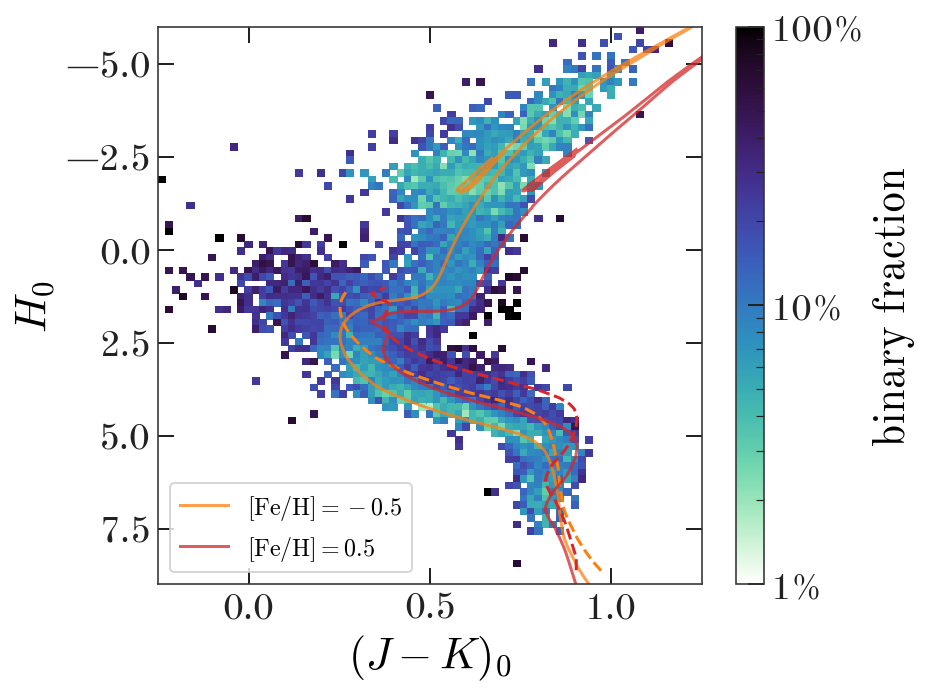

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6.5, 5))

xlim = (-0.25, 1.25)
ylim = (-6, 9)
bins = (np.arange(xlim[0], xlim[1]+1e-3, 0.02),
        np.arange(ylim[0], ylim[1]+1e-3, 0.175))

JHK0 = get_JHK0(allgaia_cut)
H, xe, ye = np.histogram2d(
    JHK0[0] - JHK0[2],
    JHK0[1] - allgaia_cut.distmod.value,
    bins=bins)

JHK0 = get_JHK0(binaries_cut)
H_binaries, *_ = np.histogram2d(
    JHK0[0] - JHK0[2],
    JHK0[1] - binaries_cut.distmod.value,
    bins=bins)

ratio = H_binaries / H
ratio[H_binaries < 2] = np.nan
# ratio = H

im = ax.pcolormesh(xe, ye, ratio.T, 
                   cmap='laguna_r', 
                   norm=mpl.colors.LogNorm(vmin=1e-2, vmax=1),
#                    vmin=0, vmax=0.5,
                   rasterized=True)

age = 9.7
for feh, color in zip([-0.5, 0.5], ['tab:orange', 'tab:red']):
    iso = at.Table.read(f'/Users/apricewhelan/data/Isochrones/MIST/FeH_{feh:.1f}_iso.fits')
    iso = iso[iso['log10_isochrone_age_yr'] == age]
    iso = iso[iso['phase'] < 4]
    ax.plot(iso['J'] - iso['Ks'], iso['H'], 
            marker='', linestyle='-', color=color, alpha=0.75,
            label=fr'$[{{\rm Fe}}/{{\rm H}}]={feh:.1f}$')
    iso = iso[iso['phase'] < 1]
    ax.plot(iso['J'] - iso['Ks'], iso['H'] - 2.5*np.log10(2), 
            marker='', linestyle='--', color=color)

ax.set_xlim(xlim)
ax.set_ylim(ylim[::-1])

ax.set_xlabel(r'$(J-K)_0$')
ax.set_ylabel(r'$H_0$')

cb = fig.colorbar(im)
cb.set_label(f'binary fraction')
cb.set_ticks([1e-2, 1e-1, 1])
cb.set_ticklabels(['1%', '10%', '100%'])

ax.legend(loc='lower left', fontsize=12)

fig.tight_layout()

# fig.savefig(os.path.join(figure_path, 'binary-CMD.pdf'), dpi=250)

## Fraction along the main sequence or up the giant branch:

In [9]:
H_mss = []
H_rgs = []
for cat in [allgaia_cut, binaries_cut]:
    X = np.stack((cat.TEFF, cat.LOGG)).T
    ms_mask = ms_path.contains_points(X)
    rg_mask = rg_path.contains_points(X)
    
    H_ms, xms = np.histogram(cat.TEFF[ms_mask], 
                             bins=np.arange(3700, 7300+1, 250))
    H_rg, xrg = np.histogram(cat.LOGG[rg_mask], 
                             bins=np.arange(0.5, 3.7+1e-3, 0.15))
    H_mss.append(H_ms)
    H_rgs.append(H_rg)
    
    xms = 0.5 * (xms[:-1] + xms[1:])
    xrg = 0.5 * (xrg[:-1] + xrg[1:])

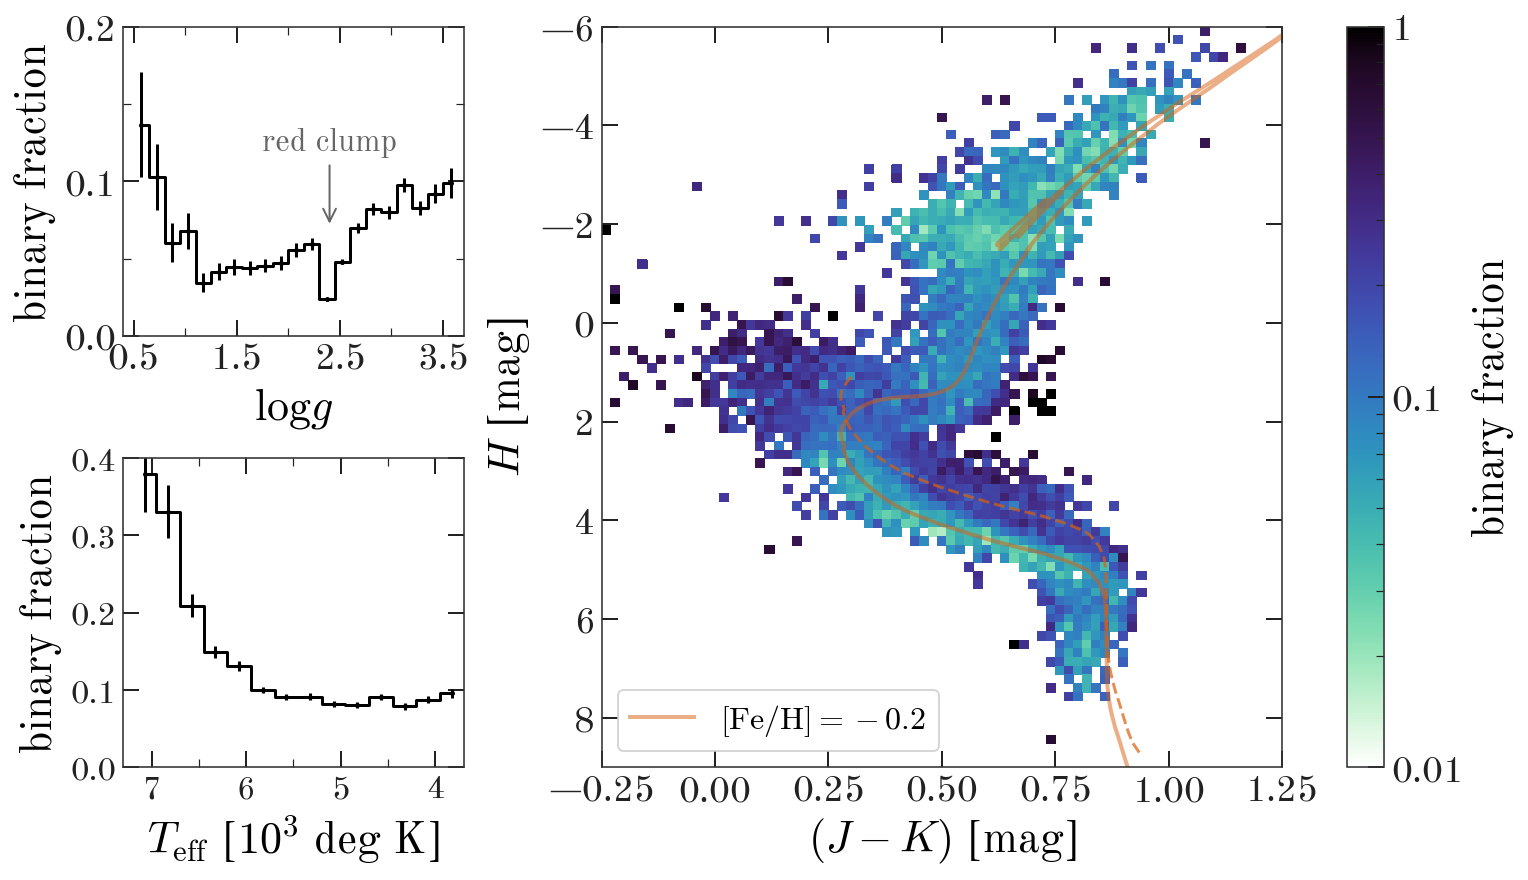

In [11]:
fig = plt.figure(figsize=(10.5, 6), constrained_layout=True)
gs = GridSpec(nrows=4, ncols=6, figure=fig)

# ---
ax = fig.add_subplot(gs[:, 2:])
xlim = (-0.25, 1.25)
ylim = (-6, 9)
bins = (np.arange(xlim[0], xlim[1]+1e-3, 0.02),
        np.arange(ylim[0], ylim[1]+1e-3, 0.175))

JHK0 = get_JHK0(allgaia_cut)
H, xe, ye = np.histogram2d(
    JHK0[0] - JHK0[2],
    JHK0[1] - allgaia_cut.distmod.value,
    bins=bins)

JHK0 = get_JHK0(binaries_cut)
H_binaries, *_ = np.histogram2d(
    JHK0[0] - JHK0[2],
    JHK0[1] - binaries_cut.distmod.value,
    bins=bins)

ratio = H_binaries / H
ratio[H_binaries < 2] = np.nan

im = ax.pcolormesh(xe, ye, ratio.T, 
                   cmap='laguna_r', 
                   norm=mpl.colors.LogNorm(vmin=1e-2, vmax=1),
#                    vmin=0, vmax=0.5,
                   rasterized=True)

age = 9.7
for feh, color in zip([-0.2], ['#d95f0e']):
    iso = at.Table.read(f'/Users/apricewhelan/data/Isochrones/MIST/FeH_{feh:.1f}_iso.fits')
    iso = iso[iso['log10_isochrone_age_yr'] == age]
    iso = iso[iso['phase'] < 4]
    ax.plot(iso['J'] - iso['Ks'], iso['H'], 
            marker='', linestyle='-', linewidth=2., 
            color=color, alpha=0.5,
            label=fr'$[{{\rm Fe}}/{{\rm H}}]={feh:.1f}$')
    iso = iso[iso['phase'] < 1]
    ax.plot(iso['J'] - iso['Ks'], iso['H'] - 2.5*np.log10(2), 
            marker='', linestyle='--', color=color, alpha=0.7)

ax.set_xlim(xlim)
ax.set_ylim(ylim[::-1])

ax.set_xlabel(r'$(J-K)$ [mag]')
ax.set_ylabel(r'$H$ [mag]')

# ax.yaxis.tick_right()
# ax.yaxis.set_label_position('right')

cb = fig.colorbar(im, aspect=35)
cb.set_label(f'binary fraction')
cb.set_ticks([1e-2, 1e-1, 1])
cb.set_ticklabels(['0.01', '0.1', '1'])

ax.legend(loc='lower left', fontsize=16)

# --------------------------------------------------------------------

ax = fig.add_subplot(gs[:2, 0:2])
err = np.std(poisson.rvs(H_rgs[1], size=(10000, len(H_rgs[1]))) / 
             poisson.rvs(H_rgs[0], size=(10000, len(H_rgs[0]))),
             axis=0)
ax.errorbar(xrg, H_rgs[1] / H_rgs[0], err, 
            marker=None, drawstyle='steps-mid',
            color='k')
ax.set_xlim(0.4, 3.7)
ax.set_ylim(0, 0.2)

ax.set_xticks(np.arange(0.5, 3.5+1e-3, 1))
ax.set_xticks(np.arange(0.5, 3.5+1e-3, 0.5), minor=True)
ax.set_ylabel('binary fraction')
ax.set_xlabel(r'$\log g$')

ax.set_yticks(np.arange(0, 0.2+1e-3, 0.1))
ax.set_yticks(np.arange(0, 0.2+1e-3, 0.05), minor=True)

ax.annotate('red clump', [2.4, 0.07], [2.4, 0.12], 
            ha='center', fontsize=16, color='#666666',
            arrowprops=dict(arrowstyle='->', color='#666666'))

# ---

ax = fig.add_subplot(gs[2:, 0:2])
err = np.std(poisson.rvs(H_mss[1], size=(10000, len(H_mss[1]))) / 
             poisson.rvs(H_mss[0], size=(10000, len(H_mss[0]))),
             axis=0)
ax.errorbar(xms/1e3, H_mss[1] / H_mss[0], err,
            marker=None, drawstyle='steps-mid',
            color='k')
ax.set_xlim(7300/1e3, 3700/1e3)
ax.set_ylim(0, 0.4)

ax.set_xticks(np.arange(4, 7+1e-3, 1))
ax.set_xticks(np.arange(4, 7+1e-3, 0.5), minor=True)
ax.set_ylabel('binary fraction')
ax.tick_params(labelsize=16)

ax.set_yticks(np.arange(0, 0.4+1e-3, 0.1))

ax.set_xlabel(r'$T_{\rm eff}$ [$10^3$ deg K]')

fig.savefig(os.path.join(figure_path, 'binary-fraction.pdf'), dpi=250)

In [26]:
H_masss = []
for cat in [allgaia_cut, binaries_cut]:
    X = np.stack((cat.TEFF, cat.LOGG)).T
    ms_mask = ms_path.contains_points(X)
    
    H_mass, xmass = np.histogram(cat.mass[ms_mask], 
                                 bins=np.geomspace(0.1, 10+1e-3, 45))
    H_masss.append(H_mass)
    
    xmass = 0.5 * (xmass[:-1] + xmass[1:])

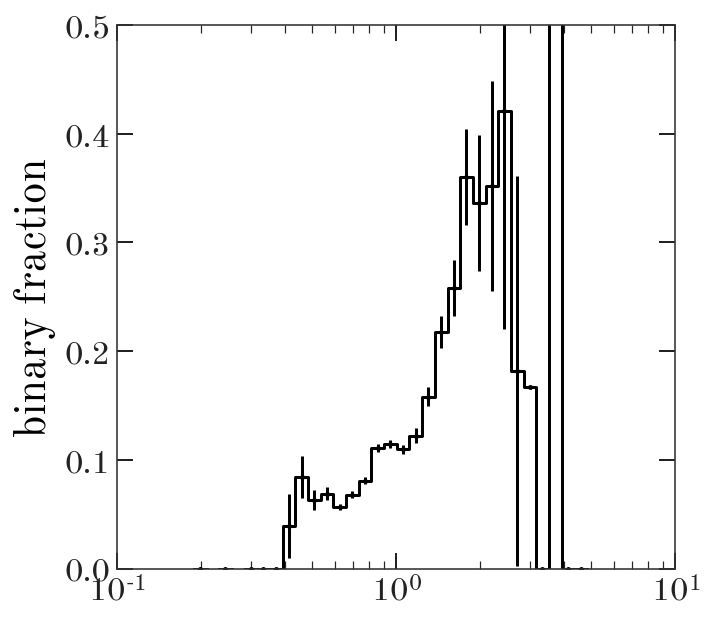

In [29]:
fig, ax = plt.subplots(figsize=(5, 5))

err = np.std(poisson.rvs(H_masss[1], size=(10000, len(H_masss[1]))) / 
             poisson.rvs(H_masss[0], size=(10000, len(H_masss[0]))),
             axis=0)
ax.errorbar(xmass, H_masss[1] / H_masss[0], err,
            marker=None, drawstyle='steps-mid',
            color='k')
ax.set_xlim(0.1, 10)
ax.set_ylim(0, 0.5)

ax.set_ylabel('binary fraction')
ax.tick_params(labelsize=16)

ax.set_xscale('log')
# ax.set_yscale('log')

# ax.set_yticks(np.arange(0, 0.4+1e-3, 0.1))

# ax.set_xlabel(r'$T_{\rm eff}$ [$10^3$ deg K]')

---

## Chemistry

In [11]:
H_fehs = []
for cat in [allgaia_cut, binaries_cut]:
    X = np.stack((cat.TEFF, cat.LOGG)).T
    
    feh_mask = ms_path.contains_points(X) & (cat.TEFF < 6500)
    
    H_feh, xfeh = np.histogram(cat.M_H[feh_mask], 
                             bins=np.arange(-2, 0.5+1e-3, 0.1))
    H_fehs.append(H_feh.astype('f8'))
    xfeh = 0.5 * (xfeh[:-1] + xfeh[1:])

In [15]:
np.polyfit(xfeh[mask], 
           (H_fehs[1] / H_fehs[0])[mask], 
           deg=1,
           w=1/err[mask]**2)

array([-0.09403142,  0.08452555])

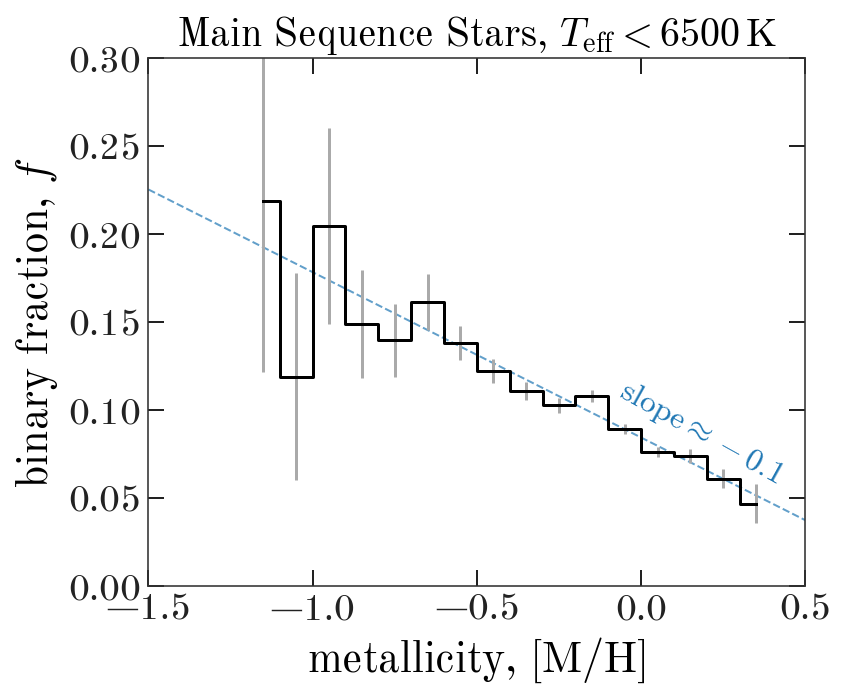

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

err = np.std(poisson.rvs(H_fehs[1], size=(10000, len(H_fehs[1]))) / 
             poisson.rvs(H_fehs[0], size=(10000, len(H_fehs[0]))),
             axis=0)

mask = H_fehs[1] > 4
ax.errorbar(xfeh[mask], 
            (H_fehs[1] / H_fehs[0])[mask], 
            err[mask], 
            marker='', drawstyle='steps-mid',
            color='k', linewidth=1.5, elinewidth=1.5, 
            ecolor='#aaaaaa')
ax.set_xlim(-1.5, 0.5)
ax.set_ylim(0, 0.3)

feh_grid = np.linspace(-1.5, 0.5, 256)
ax.plot(feh_grid, -0.094 * (feh_grid - 0.) + 0.0845,
        marker='', ls='--', color='tab:blue', lw=1, 
        zorder=-10, alpha=0.7)
ax.text(0.45, 0.12, ha='right', va='top',
        s=r'${\rm slope} \approx -0.1$',
        rotation=-29,
        fontsize=16, color='tab:blue')

# ax.set_xticks(np.arange(0.5, 3.5+1e-3, 0.5))
ax.set_ylabel('binary fraction, $f$')
ax.set_xlabel(r'metallicity, $[{\rm M}/{\rm H}]$')
ax.set_title(r'Main Sequence Stars, $T_{\rm eff}<6500\,{\rm K}$', fontsize=20)

fig.tight_layout()

fig.savefig(os.path.join(figure_path, 'fraction_M_H.pdf'))